In [1]:
cd ../..

/home/cridonoso/Documents/astromer


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import sys,os
from core.data import load_dataset, pretraining_pipeline, pretraining_pipeline_nsp

%load_ext autoreload
%autoreload 2

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2022-03-18 13:20:23.073609: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-18 13:20:23.073626: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# ASTROMER input format

In [13]:
dataset_name = 'testing'
dataset_path = './data/records/{}/fold_0/{}/train/'.format(dataset_name, dataset_name)
dataset = load_dataset(dataset_path, repeat=1, shuffle=True)
dataset = pretraining_pipeline(dataset, batch_size=256, max_obs=200, msk_frac=0.5, rnd_frac=0.2, same_frac=0.2)
objects = pd.read_csv('./data/records/{}/fold_0/{}/objects.csv'.format(dataset_name, dataset_name))
objects

[INFO] Shuffling
[INFO] Pretraining mode. Random 200-len windows


,label,size
0,Cep_0,939
1,LPV,2443


tf.Tensor([0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.], shape=(20,), dtype=float32)


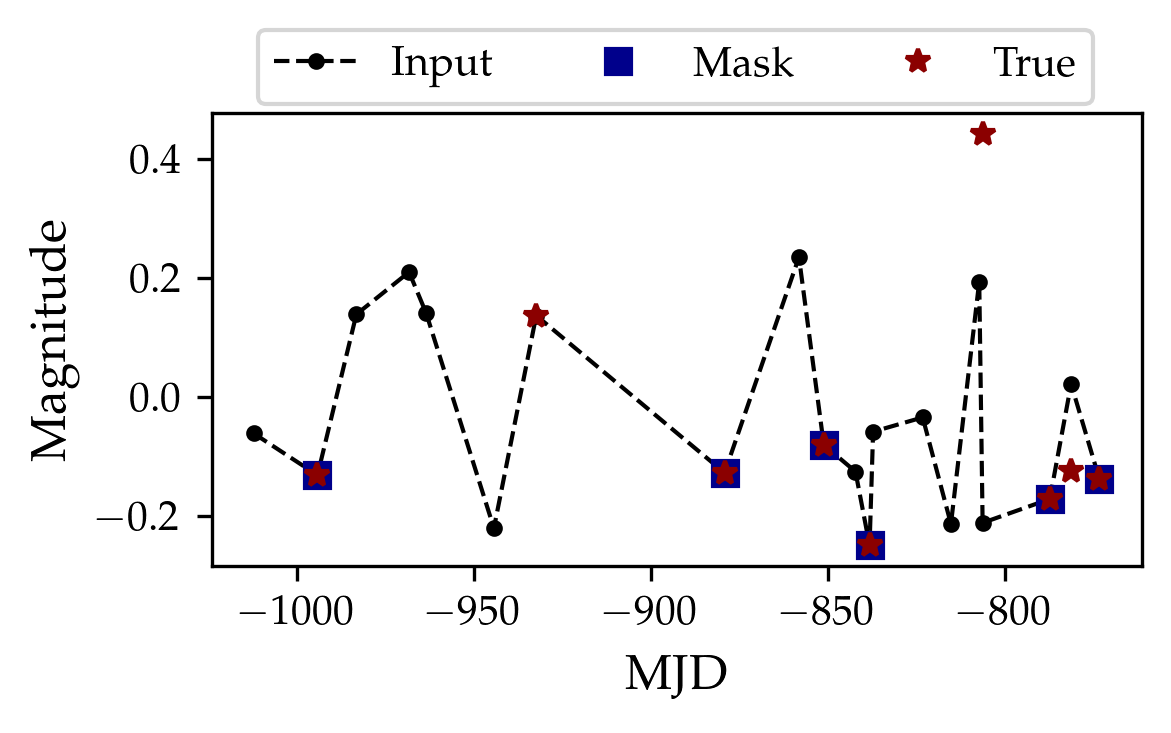

In [17]:
fig, axes = plt.subplots(1, 1, figsize=(4,2), sharex=True, sharey=True, 
                         gridspec_kw={'hspace': 0.3, 'wspace': 0.2}, dpi=300)
lim = 20
start = 0

for i, (batch, (target, _, mask)) in enumerate(dataset):
    x_input  = batch['input'][-1][start:start+lim]
    t_sample = batch['times'][-1][start:start+lim]
    x_output = target[-1][start:start+lim]
    
    
    mask_in  = tf.squeeze(batch['mask_in'][-1][start:start+lim])
    print(mask_in)
    mask_out = tf.squeeze(mask[-1][start:start+lim])


    times_masked = tf.boolean_mask(t_sample, mask_in)
    serie_masked = tf.boolean_mask(x_input, mask_in)


    times_masked_out = tf.boolean_mask(t_sample, mask_out)
    serie_masked_out = tf.boolean_mask(x_input, mask_out)

    axes.plot(t_sample, x_output, color='k', linestyle='--', marker='.', label='Input', linewidth=1)
    axes.plot(times_masked, serie_masked, marker='s', linestyle='', color='darkblue', label='Mask', linewidth=1)
    axes.plot(times_masked_out, serie_masked_out, color='darkred', linestyle='', marker='*', label='True', linewidth=1)

    axes.set_xlabel('MJD', fontsize=12)
    axes.set_ylabel('Magnitude', fontsize=12)    
    axes.legend(ncol=3, bbox_to_anchor=(0.97, 1.23))
    break

In [15]:
# fig.savefig('./presentation/figures/input.pdf', format='pdf', bbox_inches='tight')

# Classification input 

In [12]:
import tensorflow as tf 
import os, sys
import matplotlib.pyplot as plt
from core.data import balanced_records

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
df_labels = pd.read_csv('./data/records/naul_macho/fold_0/naul_macho/objects.csv')
class_names = df_labels['label'].values
n_classes = len(class_names)
df_labels

,label,size
0,Ceph 1st,556
1,Ceph Fund,964
2,EB,5389
3,LPV WoodA,255
4,LPV WoodB,658
5,LPV WoodC,888
6,LPV WoodD,630
7,RRL + GB,185
8,RRL AB,5976
9,RRL C,1420


In [48]:
dataset = balanced_records('./data/records/ogle/fold_0/ogle/train/', 256, n_classes=n_classes, max_obs=200)

In [49]:
for batch, y in dataset:
    print(batch.keys())
    break

dict_keys(['input', 'times', 'mask_in'])


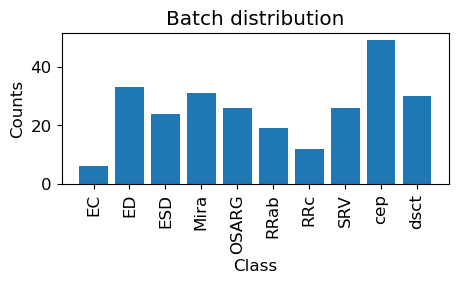

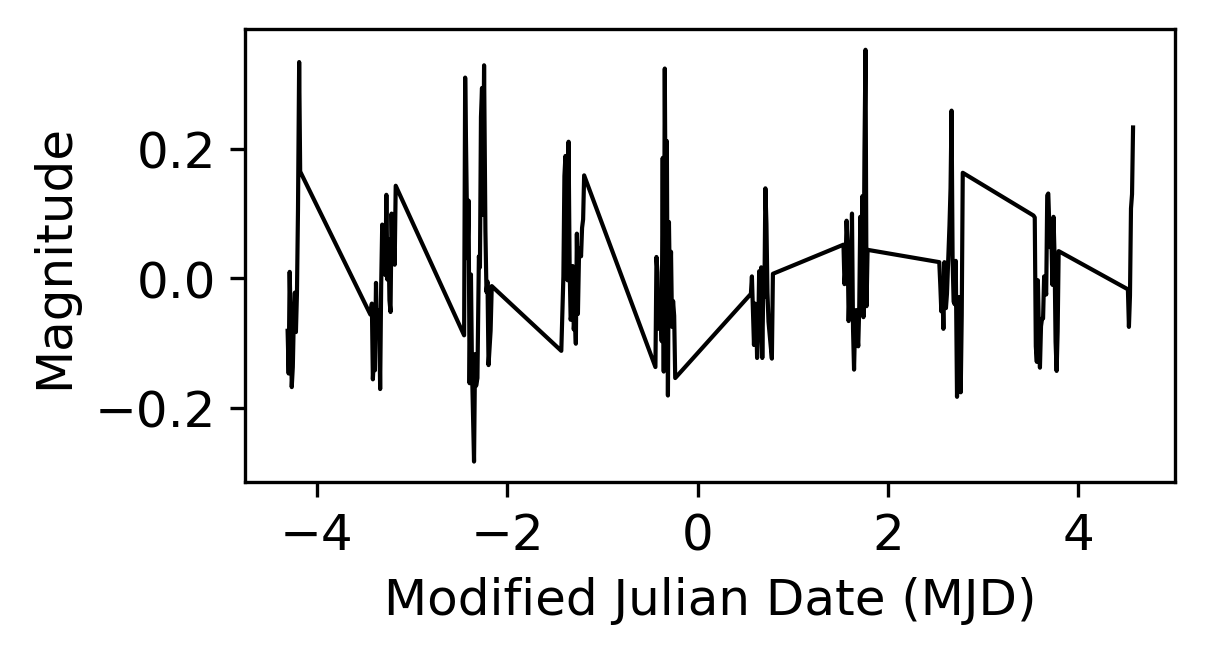

In [57]:
plt.rcParams.update({'font.size': 12})
for batch, y in dataset:
    y_label  = y[-1]
    x_input  = batch['input'][-1]
    t_sample = batch['times'][-1]
    
    mask_in  = tf.squeeze(batch['mask_in'][-1])

    times_masked = tf.boolean_mask(t_sample, mask_in)
    serie_masked = tf.boolean_mask(x_input, mask_in)
    
    # BATCH DISTRIBUTION
    plt.figure(figsize=(5,2), dpi=100)
    batch_labels = np.argmax(y.numpy(), 1)
    uniques, counts = np.unique(batch_labels, return_counts=True)
    x = range(len(uniques))
    plt.bar(x, counts)
    plt.xticks(x, class_names[:len(uniques)], rotation=90)
    plt.title('Batch distribution')
    plt.xlabel('Class')
    plt.ylabel('Counts')
    plt.show()
    
    # Lightcurve
    fig, axes = plt.subplots(1, 1, figsize=(4,2), sharex=True, sharey=True, 
                             gridspec_kw={'hspace': 0.3, 'wspace': 0.2}, dpi=300)
    axes.plot(t_sample, x_input, color='k', linestyle='-', marker='', label='Input', linewidth=1)
#     axes.set_title('{}'.format(str(class_names[y_label])))
    axes.set_xlabel('Modified Julian Date (MJD)')
    axes.set_ylabel('Magnitude')   
#     fig.savefig('presentation/figures/raw_input.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    break

## Next Sentence Prediction 

In [19]:
dataset_name = 'testing'
dataset_path = './data/records/{}/fold_0/{}/train/'.format(dataset_name, dataset_name)
dataset = load_dataset(dataset_path, repeat=1, shuffle=True)
dataset = pretraining_pipeline_nsp(dataset, batch_size=256, max_obs=200, 
                                   msk_frac=0.5, rnd_frac=0.2, same_frac=0.2, 
                                   nsp_proba=0.5)
objects = pd.read_csv('./data/records/{}/fold_0/{}/objects.csv'.format(dataset_name, dataset_name))
objects

[INFO] Shuffling
[INFO] Pretraining mode. Random 200-len windows


,label,size
0,Cep_0,939
1,LPV,2443


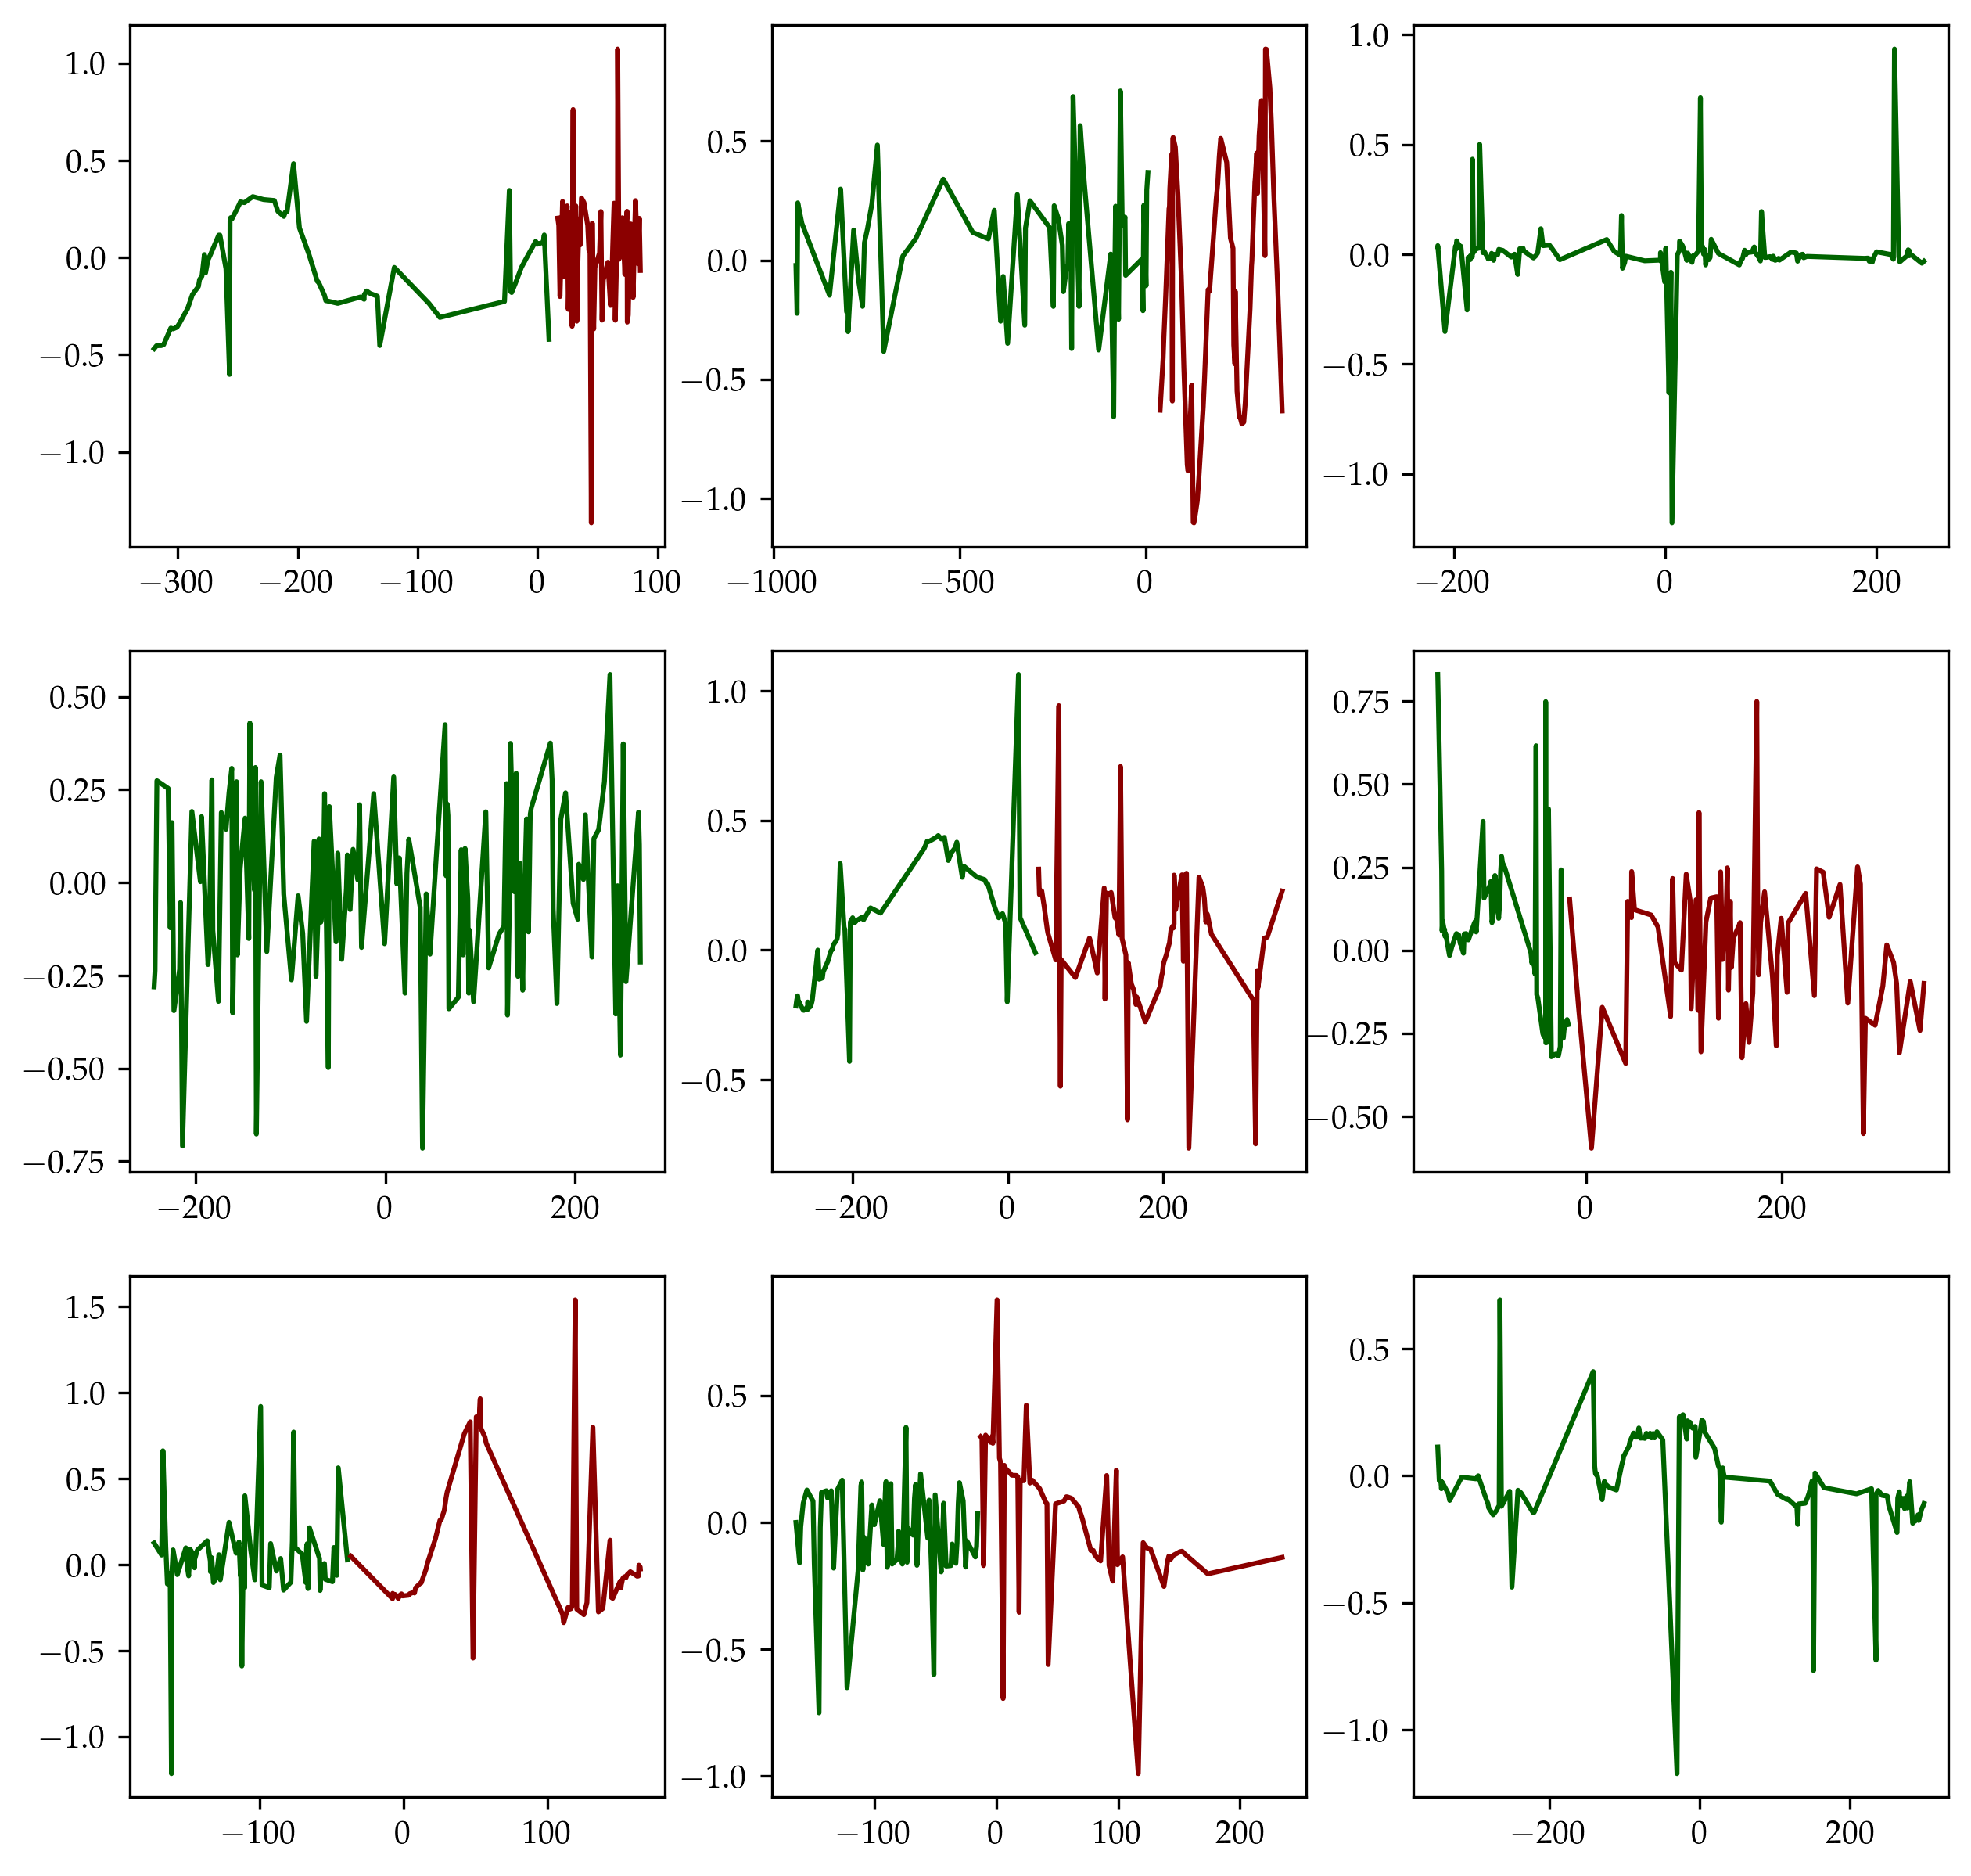

In [22]:
N=3
fig, axes = plt.subplots(N, 3, figsize=(10,10), dpi=300)
for (x, (y, label, mask)), ax in zip(dataset.unbatch().take(N*3), axes.ravel()):

    x_inp = tf.boolean_mask(x['input'], 1.-x['mask_in'])
    x_time = tf.boolean_mask(x['times'], 1.-x['mask_in'])

    indices = tf.where(x_inp<=-98)[:, 0]

    first_segm = tf.slice(x_inp, [1], [indices[1]-1])    
    first_time = tf.slice(x_time, [1], [indices[1]-1])

    ax.plot(first_time, first_segm, color='darkgreen')
    
    if label == 0:
        if len(indices)>3:
            t = tf.boolean_mask(x['input'], mask)
            print(t)
            ax.set_title('raro')
            values = x_inp.numpy()[indices.numpy()]
            print(values)
        secon_segm = tf.slice(x_inp, [indices[1]+1], [indices[-1]-indices[1]-1])
        secon_time = tf.slice(x_time, [indices[1]+1], [indices[-1]-indices[1]-1])
        ax.plot(secon_time, secon_segm, color='darkred')
    
